In [1]:
#import dependencies

import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
# directly download the data through tensorflow/keras utils api
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_file = tf.keras.utils.get_file("cats_and_dogs_filtered.zip",origin = URL,extract=True)

In [3]:
# paths of respective classes
path = os.path.join(os.path.dirname(zip_file), 'cats_and_dogs_filtered')
train_dir = os.path.join(path, 'train')
valid_dir = os.path.join(path, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # path of train cat images
train_dogs_dir = os.path.join(train_dir, 'dogs') # path of train dog images
valid_cats_dir = os.path.join(valid_dir, 'cats') # path of valid cat images
valid_dogs_dir = os.path.join(valid_dir, 'dogs')  #path of valid dog images

In [4]:
# list of filenames
num_train_cats = len(os.listdir(train_cats_dir))
num_train_dogs = len(os.listdir(train_dogs_dir))

num_val_cats = len(os.listdir(valid_cats_dir))
num_dogs_val = len(os.listdir(valid_dogs_dir))

In [5]:
#initializing necessary variables

HEIGHT,WIDTH=224,224
BATCH_SIZE= 32
EPOCHS = 20
NUM_TRAINING_IMAGES = num_train_cats+num_train_dogs
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES//BATCH_SIZE
VERBOSE=1
MODEL_PATH = "."

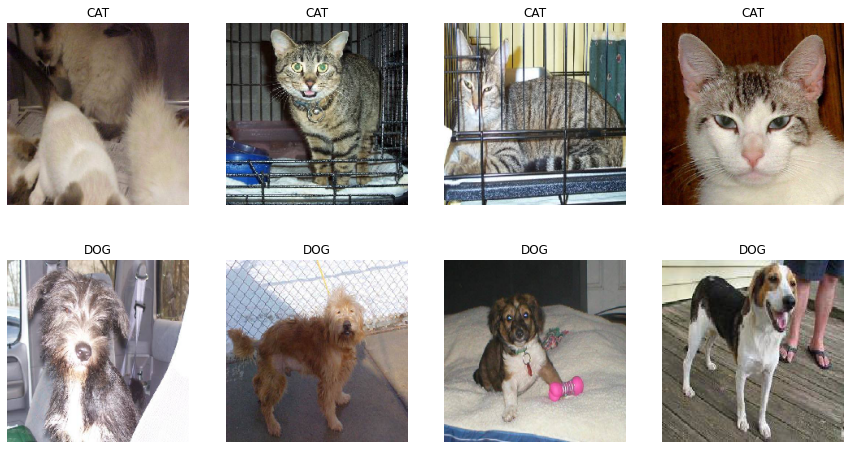

In [6]:
# visualize the images

train_cats_ls = os.listdir(train_cats_dir)
train_dogs_ls = os.listdir(train_dogs_dir)
train_ls = [train_cats_ls,train_dogs_ls]
dir_ls = [train_cats_dir,train_dogs_dir]
title = ["CAT","DOG"]

plt.figure(figsize=(15,8))
for i in range(2):
  for j in range(4):
    if i==1:
      j=j+4
    plt.subplot(2,4,j+1)
    img = tf.keras.preprocessing.image.load_img(
      os.path.join(dir_ls[i],train_ls[i][j]),target_size = (HEIGHT,WIDTH)
    )
    arr = tf.keras.preprocessing.image.img_to_array(img)
    plt.imshow(arr.astype("uint8"))
    plt.title(title[i])
    plt.axis("off")

plt.show()

In [7]:
#train generator with augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# train data
train_data = train_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(HEIGHT,WIDTH),
                                                     class_mode='binary')

# valid generator (only rescaling)
valid_generator =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_data = valid_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=valid_dir,
                                                 target_size=(HEIGHT,WIDTH),
                                                 class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# this function returns model

def create_model():
    pretrained_model = tf.keras.applications.VGG16(
        weights="imagenet",
        include_top=False ,
        input_shape=[HEIGHT,WIDTH, 3]
    )
    
    inputs = tf.keras.Input(shape=(HEIGHT,WIDTH, 3))
    x = pretrained_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [9]:
#@title Custom keras Loss
# custom binary loss function

'''class BinaryLossFn(tf.keras.losses.Loss):
  def __init__(self,from_logits=False,label_smoothing=0.,reduce_dim=True,**kwargs):
    self.from_logits=from_logits
    self.label_smoothing = label_smoothing
    self.reduce_dim=reduce_dim
    super().__init__(**kwargs)

  def call(self,y_true,y_pred):

    y_true = y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing       # apply label smoothing

    if self.from_logits:                  # if from_logits =True, convert them to (0,1) range from (-inf,+inf)
        y_pred_exp = tf.math.exp(-1 * y_pred)
        y_pred = 1 / (1 + y_pred_exp)

    if tf.rank(y_true) == 2:
        batch_size = tf.shape(y_pred)[1]
        batch_size = tf.cast(batch_size,tf.float32)
        N = tf.shape(y_pred)[0] * tf.shape(y_pred)[1]
        N = tf.cast(N,tf.float32)
    elif tf.rank(y_true) == 1:
        N = tf.shape(y_pred)[0]
        N = tf.cast(N,tf.float32)
    else:             # if shape of input tensor is wrong then exit the code
        loss = "Wrong Input"
        print("Error in input shape")
        exit()

    y_pred_log = tf.math.log(y_pred)
    y_pred_minus_log = tf.math.log(1 - y_pred)

    if self.reduce_dim:              # Set the dimension of output loss according to reduce_dim attribute
        if tf.rank(y_pred) == 2:
            loss_val = -1 / N * (y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)      # Binary Cross Entropy loss function equation
            loss = tf.math.reduce_sum(loss_val, axis=[0, 1])

        else:
            loss_val = -1 / N * (y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)
            loss = tf.math.reduce_sum(loss_val, axis=-1)

    else:
        if tf.rank(y_pred) == 2:
            loss_val = -1 / batch_size * (y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)
            loss = tf.math.reduce_sum(loss_val, axis=-1)

        else:
            loss = -1 * (y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)

    return loss
    
  def get_config(self):
    base_config = super().get_config()
    return {**base_config,"from_logits":self.from_logits,"label_smoothing":self.label_smoothing,"reduce_dim":self.reduce_dim}'''

'class BinaryLossFn(tf.keras.losses.Loss):\n  def __init__(self,from_logits=False,label_smoothing=0.,reduce_dim=True,**kwargs):\n    self.from_logits=from_logits\n    self.label_smoothing = label_smoothing\n    self.reduce_dim=reduce_dim\n    super().__init__(**kwargs)\n\n  def call(self,y_true,y_pred):\n\n    y_true = y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing       # apply label smoothing\n\n    if self.from_logits:                  # if from_logits =True, convert them to (0,1) range from (-inf,+inf)\n        y_pred_exp = tf.math.exp(-1 * y_pred)\n        y_pred = 1 / (1 + y_pred_exp)\n\n    if tf.rank(y_true) == 2:\n        batch_size = tf.shape(y_pred)[1]\n        batch_size = tf.cast(batch_size,tf.float32)\n        N = tf.shape(y_pred)[0] * tf.shape(y_pred)[1]\n        N = tf.cast(N,tf.float32)\n    elif tf.rank(y_true) == 1:\n        N = tf.shape(y_pred)[0]\n        N = tf.cast(N,tf.float32)\n    else:             # if shape of input tensor is wrong then e

In [10]:
#@title Custom Normal Loss Function
'''def CustomBinaryLossFn(from_logits=False,label_smoothing=0.):
  def BinaryLoss(y_true,y_pred):

    y_true = y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing       
 
    if from_logits:                  
        y_pred_exp = tf.math.exp(-1 * y_pred)
        y_pred = 1 / (1 + y_pred_exp)

    y_pred_log = tf.math.log(y_pred)
    y_pred_minus_log = tf.math.log(1 - y_pred)

    loss_val = -1*(y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)     
    loss = tf.math.reduce_mean(loss_val)
    return loss
  return BinaryLoss


y_true = [[0, 1], [0, 0]]
y_pred = [[-18.6, 0.51], [2.94, -12.8]]
y_pred = tf.Variable(y_pred,dtype=tf.float32)
y_true = tf.constant(y_true,dtype=tf.float32)
loss_obj = CustomBinaryLossFn(from_logits=True,label_smoothing=0.)
loss_obj(y_true,y_pred)'''

'def CustomBinaryLossFn(from_logits=False,label_smoothing=0.):\n  def BinaryLoss(y_true,y_pred):\n\n    y_true = y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing       \n \n    if from_logits:                  \n        y_pred_exp = tf.math.exp(-1 * y_pred)\n        y_pred = 1 / (1 + y_pred_exp)\n\n    y_pred_log = tf.math.log(y_pred)\n    y_pred_minus_log = tf.math.log(1 - y_pred)\n\n    loss_val = -1*(y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)     \n    loss = tf.math.reduce_mean(loss_val)\n    return loss\n  return BinaryLoss\n\n\ny_true = [[0, 1], [0, 0]]\ny_pred = [[-18.6, 0.51], [2.94, -12.8]]\ny_pred = tf.Variable(y_pred,dtype=tf.float32)\ny_true = tf.constant(y_true,dtype=tf.float32)\nloss_obj = CustomBinaryLossFn(from_logits=True,label_smoothing=0.)\nloss_obj(y_true,y_pred)'

In [11]:
import tensorflow as tf
class CustomBinaryLossFn(tf.keras.losses.Loss):
  def __init__(self,from_logits=False,label_smoothing=0.,alpha=1e-7,**kwargs):
    self.from_logits=from_logits
    self.label_smoothing = label_smoothing
    self.alpha=alpha
    super().__init__(**kwargs)

  def call(self,y_true,y_pred):

    y_true = y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing       # apply label smoothing

    if self.from_logits:                  # if from_logits =True, convert them to (0,1) range from (-inf,+inf)
        y_pred_exp = tf.math.exp(-1 * y_pred)
        y_pred = 1 / (1 + y_pred_exp)

    y_pred_log = tf.math.log(y_pred+self.alpha)
    y_pred_minus_log = tf.math.log(1 - y_pred+self.alpha)

    loss_val = -1 * (y_true * y_pred_log + (1 - y_true) * y_pred_minus_log)
    loss = tf.math.reduce_mean(loss_val)

    return loss
    
  def get_config(self):
    base_config = super().get_config()
    return {**base_config,"from_logits":self.from_logits,"label_smoothing":self.label_smoothing,"alpha":self.alpha}

y_true = [[0, 1], [0, 0]]
y_pred = [[-18.6, 0.51], [2.94, -12.8]]
y_pred = tf.Variable(y_pred,dtype=tf.float32)
y_true = tf.constant(y_true,dtype=tf.float32)
loss_obj = CustomBinaryLossFn(from_logits=True,label_smoothing=0.)
loss_obj(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8654572>

In [12]:
# function for compiling the model

def compile_model(model, lr=0.0001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    #loss = tf.keras.losses.BinaryCrossentropy()
    loss = CustomBinaryLossFn()
        
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [13]:
# callbacks function
def create_callbacks(model_save_path,verbose=1):
    
    verbose = int(verbose>0)
    
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    
    cpk_path = f'{model_save_path}/model.h5'

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=verbose
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10, 
        verbose=verbose
    )
    
    callbacks = [checkpoint, reducelr, earlystop]
    
    return callbacks

In [14]:
# printing model summary
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
# running model in GPU

with tf.device('/device:GPU:0'):
  model = create_model()
  model = compile_model(model)
  callbacks = create_callbacks(MODEL_PATH, verbose=VERBOSE)

  history = model.fit(train_data, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = valid_data,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        verbose=VERBOSE)

Epoch 1/20
62/62 [==============================] - 48s 660ms/step - loss: 0.6794 - accuracy: 0.5758 - val_loss: 1.1320 - val_accuracy: 0.5910

Epoch 00001: val_accuracy improved from -inf to 0.59100, saving model to ./model.h5
Epoch 2/20
62/62 [==============================] - 38s 609ms/step - loss: 0.5057 - accuracy: 0.7870 - val_loss: 0.2428 - val_accuracy: 0.9080

Epoch 00002: val_accuracy improved from 0.59100 to 0.90800, saving model to ./model.h5
Epoch 3/20
62/62 [==============================] - 38s 612ms/step - loss: 0.2762 - accuracy: 0.8992 - val_loss: 0.2013 - val_accuracy: 0.9150

Epoch 00003: val_accuracy improved from 0.90800 to 0.91500, saving model to ./model.h5
Epoch 4/20
62/62 [==============================] - 38s 613ms/step - loss: 0.2643 - accuracy: 0.8929 - val_loss: 0.1639 - val_accuracy: 0.9390

Epoch 00004: val_accuracy improved from 0.91500 to 0.93900, saving model to ./model.h5
Epoch 5/20
62/62 [==============================] - 38s 610ms/step - loss: 0.19

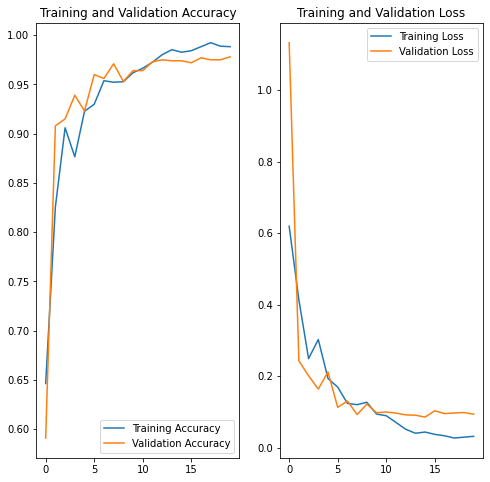

In [16]:
# Visualizing the metrics

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model = tf.keras.models.load_model("./model.h5",custom_objects={'CustomBinaryLossFn': CustomBinaryLossFn})

5.7915433e-27
0.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0


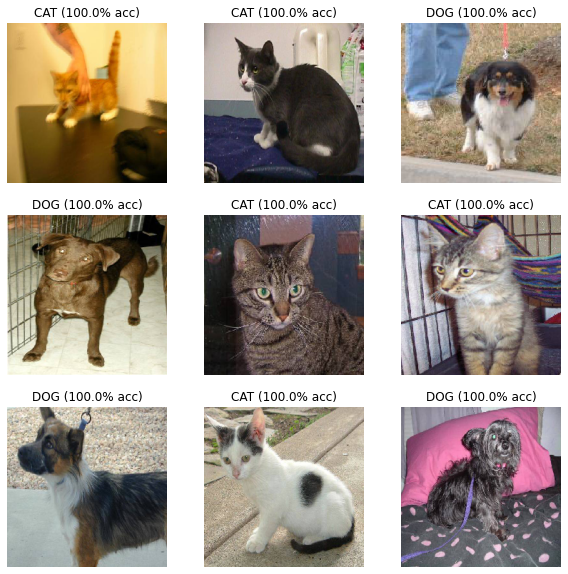

In [18]:
#predict for unseen multiple images

ls = os.listdir("/content/predict/")    # change the path accordingly
path = "/content/predict/"

img_arr=[]
predictions =[]
scores =[]
for j,i in enumerate(ls):
  img = tf.keras.preprocessing.image.load_img(
      path+i,target_size = (HEIGHT,WIDTH)
  )
  arr = tf.keras.preprocessing.image.img_to_array(img)
  img_arr.append(arr)
  arr = tf.expand_dims(arr,0)
  pred = model.predict(arr)
  prediction=pred[0][0]
  print(prediction)
  if prediction <0.5:
    predictions.append(0)
    scores.append(100*(1-prediction))
  else:
    predictions.append(1)
    scores.append(100*prediction)

scores = [round(i,2) for i in scores]
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3, i + 1)
  plt.imshow(img_arr[i].astype("uint8"))
  text = str(title[predictions[i]])+" ("+str(scores[i])+"% acc)"
  plt.title(text)
  plt.axis("off")